# Kaggle Competition | Titanic Machine Learning from Disaster

## 1. Objectives
This notebook is a simple example of data analysis aimed to deepen my personal knowledge of Python and to test the application of some Machine Learning techniques.  
The dataset that I'will use is taken from a popular Kaggle competition; all details can be found at the link [Titanic competition on Kaggle](https://www.kaggle.com/c/titanic).  
In this notebook I will focus on doing some illustrative data analysis and I’ll use Decision-Tree and Random-Forest models to predict survival on the Titanic.

## 2. Data Understanding
### 2.1 Import Libraries
First of all we need to import all the Python libraries that will be used in this notebook

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

### 2.2 Load Data

In [135]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head() # Shows a preview of the train dataset

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Variable Description**  
*Survived*: Survived (1) or died (0)  
*Pclass*: Passenger's class  
*Name*: Passenger's name  
*Sex*: Passenger's sex  
*Age*: Passenger's age  
*SibSp*: Number of siblings/spouses aboard  
*Parch*: Number of parents/children aboard  
*Ticket*: Ticket number  
*Fare*: Fare  
*Cabin*: Cabin  
*Embarked*: Port of embarkation  

[More info on kaggle webpage](https://www.kaggle.com/c/titanic/data)

### 2.3 Statistical summaries and visualizations
In this section I will perform some exploratory data anlysis to better understand the given dataset

* **Handling missing data in train dataset**  
From a first analysis we discovered some missing values that needs to be fixed before applying modeling techniques  

In [136]:
# Substitute each missing age value with the median of all age values
train['Age'] = train['Age'].fillna(train['Age'].median())
# Substitute each missing values in Embarked with class "S"
train["Embarked"] = train["Embarked"].fillna("S")

* **Get a summary of the train dataset**

In [137]:
print "Num rows: {}, Num columns: {}".format(train.shape[0], train.shape[1])
desc = train.describe()
desc.ix[['count', 'min', 'max']]

Num rows: 891, Num columns: 12


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,891.00,891.0,891.0,891.0000
min,1.0,0.0,1.0,0.42,0.0,0.0,0.0000
max,891.0,1.0,3.0,80.00,8.0,6.0,512.3292


* **Get number of passengers that survived vs passengers that passed away (male vs female)**

In [138]:
# Passengers that survived vs passengers that passed away
surv_all = train['Survived'].value_counts()
surv_all.name = 'total #'
# Males that survived vs males that passed away
surv_male = train['Survived'][train['Sex']=='male'].value_counts()
surv_male.name = 'male #'
# Females that survived vs Females that passed away
surv_female = train['Survived'][train['Sex']=='female'].value_counts()
surv_female.name = 'female #'

df = pd.concat([surv_male, surv_female, surv_all], axis=1)
df.rename(index={0: 'died', 1: 'survived'})

,male #,female #,total #
died,468,81,549
survived,109,233,342


* **Get percentage of passengers that survived vs passengers that passed away (male vs female)**

In [139]:
# Passengers that survived vs passengers that passed away normized
surv_all_perc = (train['Survived'].value_counts(normalize=True) * 100).map('{:,.2f}'.format)
surv_all_perc.name = 'total %'
# Males that survived vs males that passed away normalized
surv_male_perc = (train['Survived'][train['Sex']=='male'].value_counts(normalize=True) * 100).map('{:,.2f}'.format)
surv_male_perc.name = 'male %'
# Females that survived vs Females that passed away normalized
surv_female_perc = (train['Survived'][train['Sex']=='female'].value_counts(normalize=True) * 100).map('{:,.2f}'.format)
surv_female_perc.name = 'female %'

df = pd.concat([surv_male_perc, surv_female_perc, surv_all_perc], axis=1)
df.rename(index={0: 'died', 1: 'survived'})

,male %,female %,total %
died,81.11,25.80,61.62
survived,18.89,74.20,38.38


* **Plot some results**

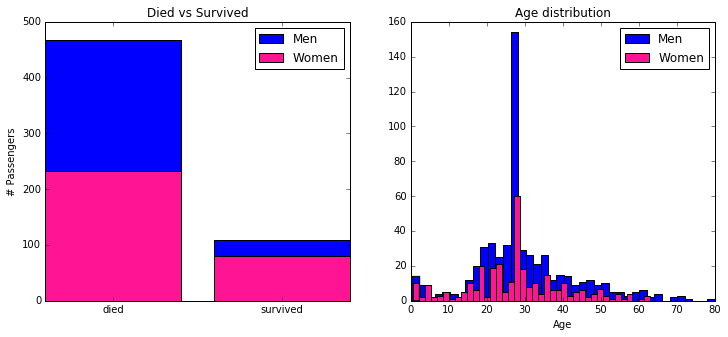

In [141]:
plt.subplots(nrows=1,ncols=2,figsize=(12,5))
# Stacked bar plot
plt.subplot(1,2,1) 
ind = np.arange(2) 
p1 = plt.bar(ind, surv_male)
p2 = plt.bar(ind, surv_female, color='#FF1493')
plt.ylabel('# Passengers')
plt.title('Died vs Survived')
plt.xticks([0.4, 1.4], ('Died', 'Survived'))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))
# Histograms
plt.subplot(1,2,2) 
p1 = plt.hist(train[train['Sex']=='male']['Age'], bins=40, label='Men')
p2 = plt.hist(train[train['Sex']=='female']['Age'], color='#FF1493', bins=40, label='Women')
plt.title('Age distribution')
plt.xlabel('Age')
plt.legend()

plt.show()

## 3. Data Preparation and Feature Engineering

### 3.1 Prepare Training Dataset
Some model algorithms can only handle numeric values, so we need to create new variables to transform categorical variables to numeric variables. Furthermore it can be useful to create new variables that could be strongly relevant and may help the model to perform better

* **Assign 1 to male passengers and 0 to female**

In [142]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x=="male" else 0)

* **Convert the Embarked classes to integer form (S=0, C=1, Q=2)**

In [143]:
train['Embarked'] = train['Embarked'].apply(lambda x: 2 if x=='Q' else 1 if x=='C' else '0')

* **Assign 1 to passengers under 18 and 0 to the others**

In [144]:
# Add a new column "Child"
train['Child'] = train['Age'].apply(lambda x: 1 if x < 18 else 0)

In [145]:
# Shows a preview of the train dataset
train.ix[5:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child
5,6,0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,NaN,2,0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,0,0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,0,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,0,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,1,1
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,4.0,1,1,PP 9549,16.7000,G6,0,1


### 3.2 Prepare Test Dataset
Models are trained on the training dataset. In order to apply these models on the test dataset, we need to make the same adjustments we did before on the training dataset

* **Substitute each missing age value with the median of all age values**

In [146]:
test["Age"] = test["Age"].fillna(test["Age"].median())

* **Replace NaN value in Fare column with median of other values**

In [147]:
# Find NaN values
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [148]:
test['Fare'].loc[152] = test['Fare'].median()

* **Assign 1 to male passengers and 0 to female**

In [149]:
test['Sex'] = test['Sex'].apply(lambda x: 1 if x=="male" else 0)

* **Convert the Embarked classes to integer form (S=0, C=1, Q=2)**

In [150]:
test['Embarked'] = test['Embarked'].apply(lambda x: 2 if x=='Q' else 1 if x=='C' else '0')

## 4. Modeling

### 4.1 Decision Tree Model
First of all we need to select the rigth features/variables to inculde in the final training dataset. Let's start using a simple set of 4 variables: Pclass, Sex, Age, Fare

In [151]:
train_X = train[["Pclass", "Sex", "Age", "Fare"]].values
train_y = train['Survived'].values

#### 4.1.1 First Model

In [152]:
model_1 = tree.DecisionTreeClassifier()
model_1 = model_1.fit(train_X, train_y)

* **Compute model performance on the training dataset**

In [153]:
print "Model_1 mean accuracy: {} %".format(model_1.score(train_X, train_y) * 100)

Model_1 mean accuracy: 97.7553310887 %


In [154]:
# Gini importance
model_1.feature_importances_

array([ 0.12126833,  0.31274009,  0.24395654,  0.32203504])

#### 4.1.2 Second Model
Include additional features in the training dataset

In [155]:
train_X = train[["Pclass","Sex","Age","Fare", "SibSp", "Parch", "Embarked"]].values

In [156]:
model_2 = tree.DecisionTreeClassifier()
model_2 = model_2.fit(train_X, train_y)

In [157]:
print "Model_2 mean accuracy: {} %".format(model_2.score(train_X, train_y) * 100)

Model_2 mean accuracy: 97.9797979798 %


By adding the additional features the performance of the model are slightly better 

### 4.2 Random Forest Model

In [158]:
# Building and fitting my_forest
model_3 = RandomForestClassifier()
model_3 = model_3.fit(train_X, train_y)
# max_depth = 10, min_samples_split=2, n_estimators = 100, random_state = 1

In [159]:
print "Model_3 mean accuracy: {} %".format(model_3.score(train_X, train_y) * 100)

Model_3 mean accuracy: 96.632996633 %


## 5 Testing the Model
Let's select the corresponding features/variables of the test dataset

In [160]:
test_X = test[["Pclass","Sex","Age","Fare", "SibSp", "Parch", "Embarked"]].values

* **Perform prediction on the test dataset and write the solution in a DataFrame**

In [161]:
pred = model_3.predict(test_X)
my_solution = pd.DataFrame(pred, index=test['PassengerId'].values, columns=['Survived'])

* **Write the solution to a csv file for final submission**

In [162]:
my_solution.to_csv("my_solution.csv", index_label = ["PassengerId"])

In [163]:
#from IPython.display import IFrame
#IFrame('https://en.wikipedia.org/wiki/Decision_tree', width=1024, height=350)

Other resources:
-----------------
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier
https://www.kaggle.com/manuelc/best-model-mixed-classifier
-----------------
https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
https://www.kaggle.com/omarelgabry/a-journey-through-titanic
https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
https://github.com/agconti/kaggle-titanic
http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb